# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

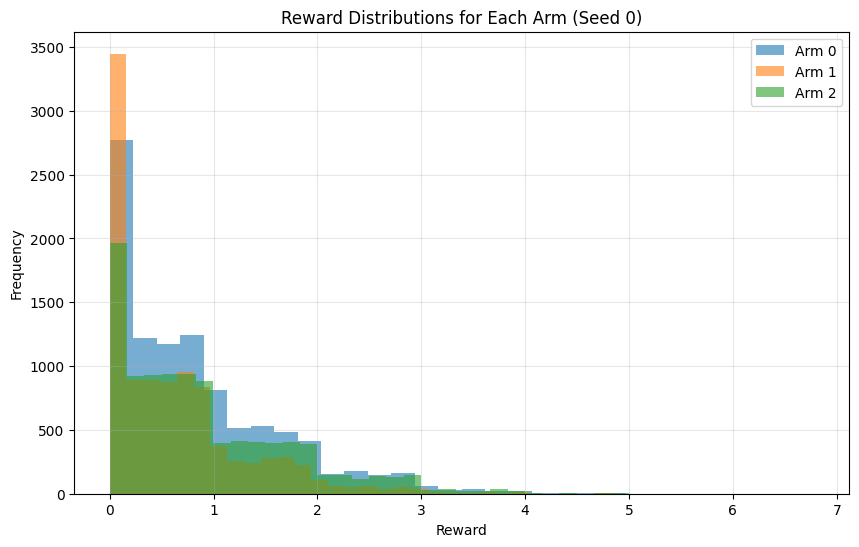

Ellipsis

In [5]:
# YOUR CHANGES HERE


import numpy as np
import matplotlib.pyplot as plt

# Use the provided BanditProblem class
bandit0 = BanditProblem(0)

num_arms = bandit0.get_num_arms()
num_samples = 10000  # how many times to pull each arm

# Collect rewards for each arm
rewards = {arm: [bandit0.get_reward(arm) for _ in range(num_samples)]
           for arm in range(num_arms)}

# Plot histograms
plt.figure(figsize=(10, 6))
for arm in range(num_arms):
    plt.hist(rewards[arm], bins=30, alpha=0.6, label=f"Arm {arm}")

plt.title("Reward Distributions for Each Arm (Seed 0)")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

...

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

In [6]:
content = """ I chose a regret-minimization approach because our goal is to maximize long-term
reward. This balances exploration with  exploitation until the best one  is identified."""

with open("algorithm-choice.txt", "w", encoding="utf-8") as f:
    f.write(content)


## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [ ]:
# YOUR CHANGES HERE


import numpy as np


def run_ucb1(bandit, T=1000, seed=2025002):
    rng = np.random.default_rng(seed)  
    K = bandit.get_num_arms()

    pulls = np.zeros(K, dtype=int)
    sums  = np.zeros(K, dtype=float)
    actions = []

    r_max = 0.0

    for a in range(K):
        r = bandit.get_reward(a)
        r_max = max(r_max, r)
        pulls[a] += 1
        sums[a]  += r
        actions.append(a)

    def ucb(a, t, rmax):
        mean = sums[a] / pulls[a]
        mean_norm = mean / (rmax if rmax > 0 else 1.0)
        return mean_norm + np.sqrt(2.0 * np.log(t) / pulls[a])

    for t in range(K + 1, T + 1):
        scores = [ucb(a, t, r_max) for a in range(K)]
        best = np.max(scores)
        candidates = [a for a, s in enumerate(scores) if s == best]
        a = rng.choice(candidates)

        r = bandit.get_reward(a)
        r_max = max(r_max, r)
        pulls[a] += 1
        sums[a]  += r
        actions.append(a)

    return actions, pulls, sums / pulls

bandit = BanditProblem(seed=2025002)
actions, counts, est_means = run_ucb1(bandit, T=1000, seed=2025002)


...

First 10 actions: [0, 1, 2, np.int64(0), np.int64(0), np.int64(1), np.int64(2), np.int64(0), np.int64(0), np.int64(1)]
Action counts: [399, 425, 176]
Estimated means: [0.5488085568762433, 0.5700245032934121, 0.19393732624073118]


Ellipsis

Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [ ]:
# YOUR CHANGES HERE


import pandas as pd

bandit = BanditProblem(seed=2025002)

actions = []
rewards = []

for _ in range(1000):
    a = np.random.randint(0, bandit.get_num_arms())  
    r = bandit.get_reward(a)
    actions.append(a)
    rewards.append(r)

df = pd.DataFrame({"action": actions, "reward": rewards})
df.to_csv("history.tsv", sep="\t", index=False)

print("history.tsv", len(df), "rows")

...

Wrote history.tsv with 1000 rows


Ellipsis

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [ ]:
# YOUR CHANGES HERE


import pandas as pd

df = pd.read_csv("history.tsv", sep="\t")

summary = (
    df.groupby("action")["reward"]
      .agg(min_reward="min", mean_reward="mean", max_reward="max")
      .reset_index()
)

summary.to_csv("actions.tsv", sep="\t", index=False)

print("actions.tsv", len(summary), "rows")

...

Wrote actions.tsv with 3 rows


Ellipsis

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [ ]:
# YOUR CHANGES HERE

...

import pandas as pd
import numpy as np

hist = pd.read_csv("history.tsv", sep="\t")
means = pd.read_csv("actions.tsv", sep="\t")

K = means["action"].nunique()
mu_star = means["mean_reward"].max()

def regret(actions):
    return np.sum(mu_star - means.set_index("action").loc[actions, "mean_reward"].values)

T = len(hist)

uniform_actions = np.random.choice(means["action"], size=T, replace=True)
regret_uniform = regret(uniform_actions)

regret_just = {i: regret([i] * T) for i in means["action"]}

regret_actual = np.sum(mu_star - hist["reward"])

# Print results
print("Expected Regret over 1000 actions:")
print(f"Uniform: {regret_uniform:.3f}")
for i, r in regret_just.items():
    print(f"Just-{i}: {r:.3f}")
print(f"Actual: {regret_actual:.3f}")


Expected Regret over 1000 actions:
Uniform: 174.444
Just-0: 0.000
Just-1: 101.561
Just-2: 387.324
Actual: 165.453


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [ ]:
# YOUR CHANGES HERE

...

import pandas as pd
import numpy as np

hist = pd.read_csv("history.tsv", sep="\t")
means = pd.read_csv("actions.tsv", sep="\t")

K = means["action"].nunique()
mu_star = means["mean_reward"].max()

def regret(actions):
    return np.sum(mu_star - means.set_index("action").loc[actions, "mean_reward"].values)

T = len(hist)

uniform_actions = np.random.choice(means["action"], size=T, replace=True)
regret_uniform = regret(uniform_actions)

regret_just = {i: regret([i] * T) for i in means["action"]}

regret_actual = np.sum(mu_star - hist["reward"])

rows = [{"strategy": "uniform", "regret": regret_uniform}]
rows += [{"strategy": f"just-{i}", "regret": r} for i, r in regret_just.items()]
rows.append({"strategy": "actual", "regret": regret_actual})

df = pd.DataFrame(rows)
df.to_csv("strategies.tsv", sep="\t", index=False)

print("strategies.tsv")


Wrote strategies.tsv


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

In [ ]:
# write_acknowledgments.py
from pathlib import Path

ACK_FILE = Path("acknowledgments.txt")
ACK_TEXT = "My dad helped me with this"

def main():
    ACK_FILE.write_text(ACK_TEXT)
    print(f"Saved acknowledgments to: {ACK_FILE.resolve()}")

if __name__ == "__main__":
    main()


Saved acknowledgments to: /workspaces/dx704-project-03/acknowledgments.txt


## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.